In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="https://raw.githubusercontent.com/malkaguillot/Foundations-in-Data-Science-and-Machine-Learning/refs/heads/main/docs/utils/custom.css">
%%HTML
<link rel="stylesheet" type="text/css" href="../utils/custom.css">

## Foundations in Data Science and Machine Learning
# Module 5c: Machine Learning - Tree-based methods
### Malka Guillot

<img src="../utils/img/logo-hsg.png" alt="HSG Logo" style="position: relative; bottom: 50px; left: 600px; width: 100px;">

### References

- [JWHT](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/601cc86d7f828c4792e0bcae/1612499080032/ISLR+Seventh+Printing.pdf), chap 8
- [Hands-On ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), chap 6, 7
- https://matteocourthoud.github.io/course/ml-econ/07_trees/#72-bagging-random-forests-boosting 



In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

## Introduction: Decision Trees and Ensemble Learning

### Decision Trees (DTs)

ML algorithms that progressively divide data sets into smaller data groups based on a descriptive feature, until they reach sets that are small enough to be described by some label.

- One of the most powerful supervized machine learning method

-  Non-parametric 

-  For classification and regression.

### Ensembe learning
- Combines serveral base model to produce one optimal predictive model     
    $\rightarrow $ *wisdom of the crowd*
    
- Focus on [XGBoost](https://arxiv.org/pdf/1603.02754.pdf): 
  - A decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.
  - Recent method (2016)

### Oveview of this family of methods
<div style="text-align: center;"><img src="images/xgboost_final.png" style="height: 200px;" > </div>

## Decision Trees
<div style="text-align: center;"><img src="images/xgboost_1_decision_tree.png" style="height: 200px;" > </div>

### Decision Trees

- A graphical representation of a segmentation of the predictor space into a number of simple regions
 
- Decision trees **learn a series of binary splits in the data based on hard thresholds**.
    - if yes, go right; if no, go left.
    - Additional splits as you move through the tree.

### What is a tree? 

<div style="display: flex; justify-content: space-between; align-items: center;">
    <div>
        <ul>
            <li>Root node</li>
            <li>Splitting</li>
            <li>Branch</li>
            <li>Decision node (internal node)</li>
            <li>Leaf node (terminal node)</li>
            <li>Sub-tree</li>
            <li>Depth (level)</li>
            <li>Pruning</li>
        </ul>
    </div>
    <div>
        <img src=images/tree.png style="text-align: center;height: 200px;">
    </div>
</div>


### Decision Trees

- **Classification trees**: 
    - when predicting a discrete variable
    - *Example*:  predicting death after contracting Covid-19

- **Regression trees**: 
    - when predicting a continuous variable
    - *Example*: predicting housing prices

### Regression Trees
#### Prediction the salary of baseball players

The `Hitters` dataset consists in individual level data of baseball players. In our applications, we are interested in predicting the players `Salary`.

In [3]:
hitters=pd.read_csv('../../data/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [4]:
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    object 
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    float6

### Using 2 explanatory variable: `Years` & `Hits`

In particular, we are interested in looking how the number of Hits and the Years of experience predict the Salary.

In [5]:
# Get Features 
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

#### `Salary` vs. `Log(Salary)`
We are actually going to use log(salary) since it has a more gaussian distribution.

In [6]:
def make_figure_hist():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))

    # Plot salary distribution
    ax1.hist(hitters.Salary.values)
    ax1.set_xlabel('Salary')
    ax2.hist(y)
    ax2.set_xlabel('Log(Salary)');
    

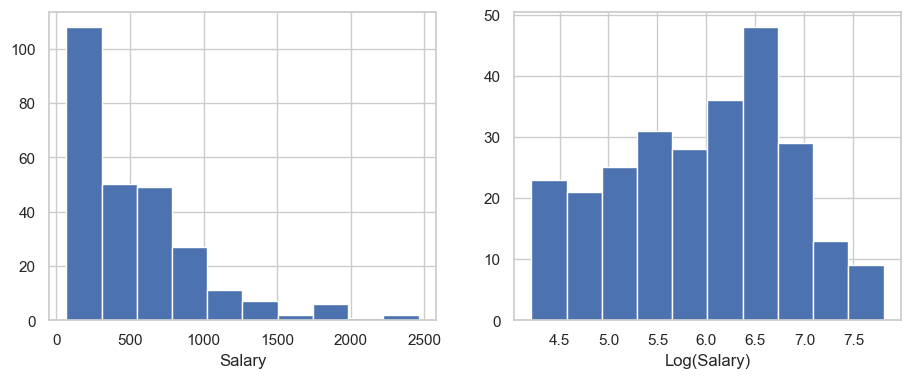

In [7]:
make_figure_hist()

In [8]:
def make_figure_hits_year():
    plt.ylabel("Hits", fontsize=16)
    plt.xlabel("Years", fontsize=16)
    plt.title("Salary : red (low) -> purple (high)", fontsize=18)
    plt.scatter(hitters['Years'], hitters['Hits'], c=hitters['Salary'], s=40,cmap='gist_rainbow')
    plt.colorbar() 

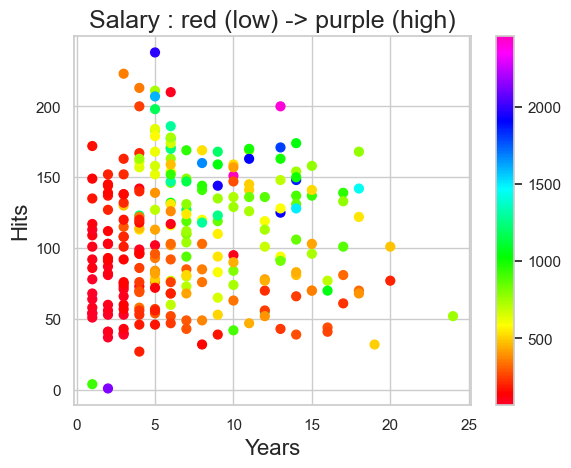

In [9]:
make_figure_hits_year()

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree._export import plot_tree

Regression tree with 3 leaves ie. 2 nodes

In [11]:
# Fit regression tree
tree = DecisionTreeRegressor(max_leaf_nodes=3)
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

#### Visualize the tree

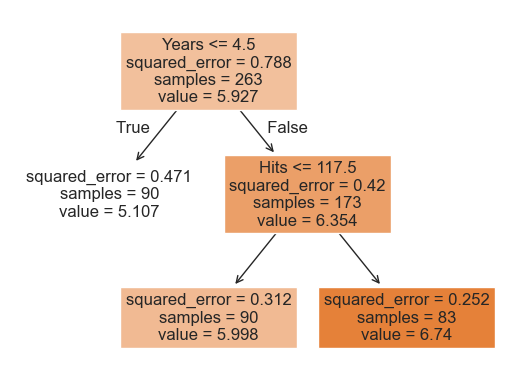

In [12]:
fig, ax = plt.subplots(1,1)
ax.set_title('Figure Decision tree');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=12, ax=ax);

The tree consists of a series of splitting rules, starting at the top of the tree. 

- The top split assigns observations having `Years`$<4.5$ to the **left branch**.
  - The predicted salary for these players is given by the mean response value for the players in the data set with `Years`$<4.5$. 
  - For such players, the mean log salary is $5.107$, and so we make a prediction of $5.107$ thousands of dollars, i.e. $165,174, for these players. 
- Players with Years>=4.5 are assigned to the **right branch**, and then that group is further subdivided by `Hits`.

Overall, the tree stratifies or segments the players into three regions of predictor space:

-  players who have played for four or fewer years
-  players who have played for five or more years and who made fewer than 118 hits last year, and
-  players who have played for five or more years and who made at least 118 hits last year.
-  
These three regions can be written as

- R1 = $\{X | \text{Years}<4.5\}$
- R2 = $\{X | \text{Years}>=4.5, Hits<117.5\}$
- R3 = $\{X | \text{Years}>=4.5, Hits>=117.5\}$



### A Visual Representation of the Data

In [13]:
def make_figure_hits_year2():
    plt.ylabel("Hits", fontsize=16)
    plt.xlabel("Years", fontsize=16)
    plt.title("3 Regions", fontsize=18)
    plt.scatter(hitters['Years'], hitters['Hits'], c=hitters['Salary'], s=10,cmap='gist_rainbow')
    plt.colorbar() 

    # Split lines
    plt.vlines(4.5, ymin=-5, ymax=250, color='g')
    plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

    # Regions
    plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
    plt.annotate('R2', xy=(11,60), fontsize='xx-large')
    plt.annotate('R3', xy=(11,170), fontsize='xx-large');

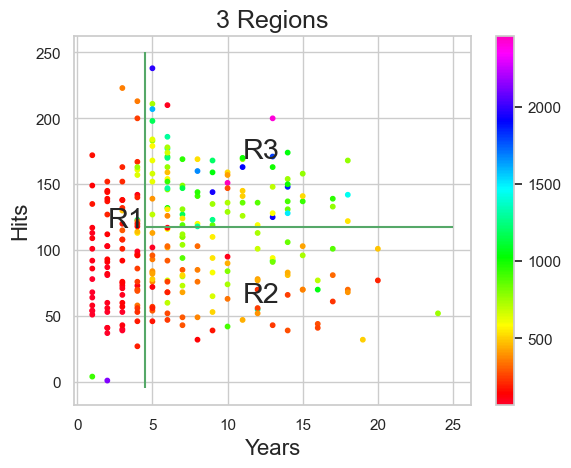

In [14]:
make_figure_hits_year2()

We might interpret the above regression tree as follows: 
- `Years` is the most important factor in determining `Salary`, and players with less experience earn lower salaries than more experienced players. 
- Given that a player is less experienced, the number of `hits` that he made in the previous year seems to play little role in his salary. 
- But among players who have been in the major leagues for five or more years, the number of hits made in the previous year does affect salary, and players who made more hits last year tend to have higher salaries.

#### Challenges with Splits

Using splits in general introduces three key questions:

-   Where should the split be?
-   How many splits are optimal?
-   How to make predictions within each node?

These queries fall within the scope of the decision tree framework.

## Building a Tree

### Classification and regression trees (CART)

There are two main steps in the construction of a tree:

1.  We divide the predictor space—that is the set of possible values for $X_1, X_2, \cdots ,X_p$ into $J$ distinct and non-overlapping regions $R_1, R_2, \cdots, R_j$
.
1. For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$. 
   - For example, for a continuous $y$,
$$\hat{y}_{j}=\frac{1}{N_{j}} \sum_{x_{i} \in R_{j}} y_{i}$$

### The Splitting Process: How does it work?

- Going over every possible partitions of the feature space is *infeasible*.

- Instead, the CART algorithm follows a **greedy** approach.

- Starting with all of the data, consider a splitting variable $j$ and split point $s$, and define the pair of half-planes
$$R_{1}(j, s)=\left\{x | x_{j} \leq s\right\}, \qquad R_{2}(j, s)=\left\{x | x_{j}>s\right\}$$
- Find the predictor $j^*$ and split $s^*$ that partitions the data into 2 regions $R_{1}(j^*,s^*)$ and $R_{2}(j^*,s^*)$ such that the overall sums of squares error are minimized:
$$\mathrm{RSS}=\sum_{i \in R_{1}(j^*,s^*)}\left(y_{i}-\bar{y}_{1}\right)^{2}+\sum_{i \in R_{2}(j^*,s^*)}\left(y_{i}-\bar{y}_{2}\right)^{2}$$
where $\bar{y}_{1}$ and $\bar{y}_{2}$ are the averages of the training set outcomes within each group.

### The CART Algorithm

Begin with the root node, containing the complete sample. Then:

1. Identify the single $RSS$ minimizing split for this node.

2. Split this parent node into the left and right node.

3. Apply steps 1 and 2 to each child node.

4. Repeat until reaching a leaf node of a pre-defined minimum size (for instance, cease splitting when fewer than 10 observations remain in each leaf).

### How large should we grow the tree?

- Large tree - overfit. Small tree - high variance.

- The tree's level of *expressiveness* is captured by its size (the number of terminal nodes).

- Common practice: Build a large tree and **prune** the tree backwards using *cost-complexity pruning*.


#### Cost-complexity pruning

The cost complexity criterion associated with a tree $T$ is given by

$$\mathrm{RSS}_{cp}(T)=\mathrm{RSS}(T)+cp|T|$$
where
  - $\mathrm{RSS}$ is the sum of squared error for tree $T$.
  - $|T|$ is the number of terminal nodes in tree $T$.
  - $cp$ is the complexity parameter
  - The complexity parameter is unit free and ranges from 0 to 1:
    - When $cp = 0$, we have a fully saturated tree.  
    - When $cp = 1$, there are no splits, i.e, we predict the unconditional mean.

  
Hence, for CART, the penalty is a function of the number of terminal nodes.

*NOTE:* $cp$ and $|T|$ are analogous to $\lambda$ and $\lVert\boldsymbol{\beta}\rVert_1$ in the lasso.

### Regularization Hyperparameters
- No parameter: nonparametric model
- To avoid overfitting control by the `max_depth` hyperparameter
    - `max_depth` 
    - `min_samples_split` : the min number of samples a node must have before it can be split
    - `min_samples_leaf` : the min number of samples a leaf node must have

In [15]:
# Compute tree
overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5).fit(X, y)

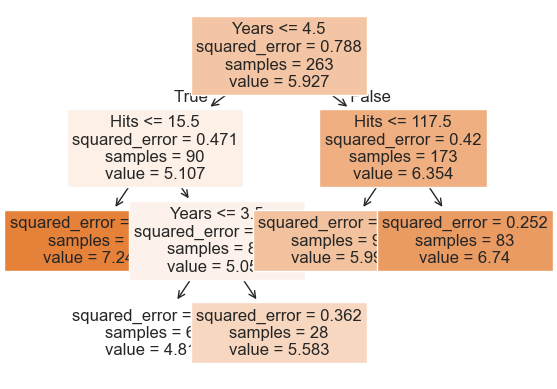

In [16]:
# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

The split on the far left is predicting a very high `Salary` ($7.243$) for players with few `Years` of experience and few `Hits`. Indeed this prediction is based on an extremely tiny subsample (2). They are probably outliers and our tree is most likely overfitting.

#### Avoid overfitting using a minimum number of observations per leaf

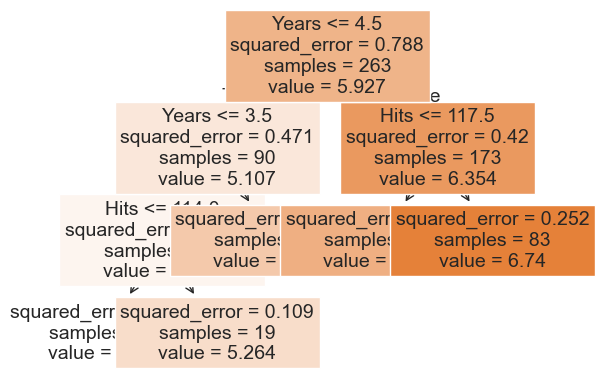

In [17]:
# Compute tree
no_overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5, min_samples_leaf=10).fit(X, y)

# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(no_overfit_tree, filled=True, feature_names=features, fontsize=14, ax=ax);

Now the tree makes much more sense: the lower the `Years` and the `Hits`, the lower the predicted `Salary` as we can see from the shades getting darker and darker as we move left to right

### Choosing optimal tree length using cross-validation

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score

In [19]:
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']
hitters=pd.read_csv('../../data/Hitters.csv').dropna()

X = hitters[features]
y =hitters['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [20]:
# Init
params = range(2,11)
reg_scores = np.zeros((len(params),3))
best_score = 10**6

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeRegressor(max_leaf_nodes=k)

    # Loop over splits
    tree.fit(X_train, y_train)
    reg_scores[i,0] = mean_squared_error(tree.predict(X_train), y_train)
    reg_scores[i,1] = mean_squared_error(tree.predict(X_test), y_test)

    # Get CV score
    kf6 = KFold(n_splits=6)
    reg_scores[i,2] = -cross_val_score(tree, X_train, y_train, cv=kf6, scoring='neg_mean_squared_error').mean()
    
    # Save best model
    if reg_scores[i,2]<best_score:
        best_model = tree
        best_score = reg_scores[i,2]


In [21]:
def make_figure_optimal_depth():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle('Choosing the right tree depth', fontsize=20) 

    # Plot scores
    ax1.plot(params, reg_scores);
    ax1.axvline(params[np.argmin(reg_scores[:,2])], c='k', ls='--')
    ax1.legend(['Train','Test','6-fold CV']);
    ax1.set_title('Cross-Validation Scores');

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);
    ax2.set_title('Best Model')

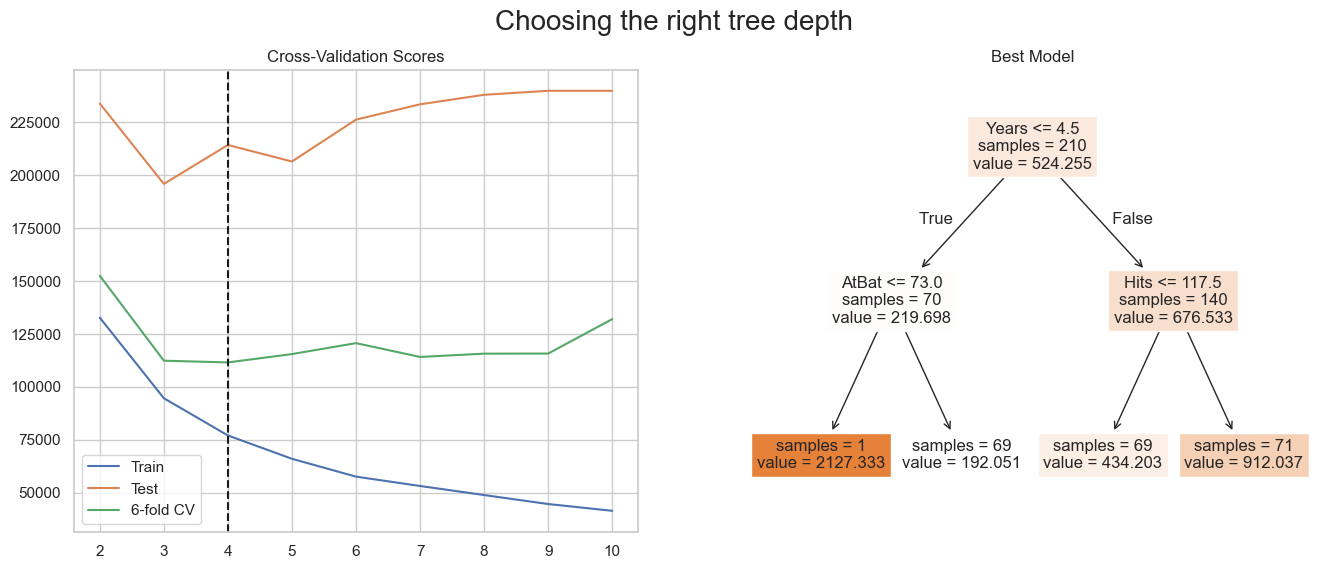

In [22]:
make_figure_optimal_depth()

The optimal tree depth is 4. 

### Classification

A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one.

For a classification tree, we predict that each observation belongs to the *most commonly occurring class* of training observations in the region to which it belongs.

### Building a Classification Tree

- Similar to the task of growing a regression tree. 
- However, RSS cannot be used as a criterion for making the binary splits.
- We define $\hat p_{mk}$ as the proportion of training observations in the $m^{th}$ region that are from the $k^{th}$ class. 

#### Possible loss functions to decide the splits are:

- Classification error rate
$$
E = 1 - \max _{k}\left(\hat{p}_{m k}\right)
$$
- Gini index
$$
G=\sum_{k=1}^{K} \hat{p}_{m k}\left(1-\hat{p}_{m k}\right)
$$

- Entropy
$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}
$$

### Pros and Cons
#### *Pros*
- Intuitive (more than regression?) 
- Simple and useful for **interpretation**.
- Nonparametric
- very little data preparation (no feature scaling needed)
- Trees can easily handle qualitative predictors without the need to create dummy variables.

#### *Cons*
- **Poor predictive performance** (typically)
- High risk of **overfit**
- Too many branches lower the variance but can increase the bias
  - trees can be **very non-robust**. 
      - In other words, a small change in the data can cause a large change in the final estimated tree.

### Extension: bagging, random forests, and boosting. 

  - These methods **grow multiple trees** which are then combined to yield a single consensus prediction.
 
  - Combining a large number of trees $\rightarrow$ 
      - dramatic improvements in **prediction accuracy**, 
      - at the expense of some **loss interpretation**.


## XGBoost Ingredient 2 -- Bagging (Bootstrapping)
<center>
<div class="r-stack"><img src="images/xgboost_2_bagging.png" style="height: 300px;" > </div>
</center>

### Bagging 

- The main problem of decision trees is that they suffer from *high variance*. 

- **Bootstrap aggregation**, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method.
  - Averaging reduce the variance

- Combines prediction from multiple decision trees through a majority votting mechanism

### Out-of-Bag Error Estimation

Very straightforward way to estimate the test error of a bagged model, without the need to perform cross-validation or the validation set approach. 

- *Bagging*: trees are repeatedly fit to bootstrapped subsets of the observations. 
- On average, each bagged tree makes use of around two-thirds of the observations. 
- The remaining one-third of the observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations. 
- We can predict the response for the ith observation using each of the trees in which that observation was OOB.

#### Example in the case of a classification
We are now going to compute the Gini index for the `Heart` dataset using different numbers of trees.

We use the `Heart` dataset on individual heart failures. We will try to use individual characteristics in order to predict heart deseases (`HD`). The varaible is binary: Yes, No.

In [23]:
# Load heart dataset
heart=pd.read_csv('../../data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


#### Pre-processing step

In [24]:
# Fastorize variables
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]
# Set features
features = [col for col in heart.columns if col!='AHD']
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [26]:
# Init (takes a lot of time with J=30)
params = range(2,50)
bagging_scores = np.zeros((len(params),2))
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=k, oob_score=True)
        bagging.fit(X2_train,y2_train)
        temp_scores[j,0] = bagging.score(X2_test, y2_test)
        temp_scores[j,1] = bagging.oob_score_
        
    # Average
    bagging_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

#### Plot of the Out-of-Bag error computed while generating the bagged estimator.

In [27]:
def make_new_figure():    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle("Estimated $R^2$")

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.legend(['Test','OOB']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('R^2');

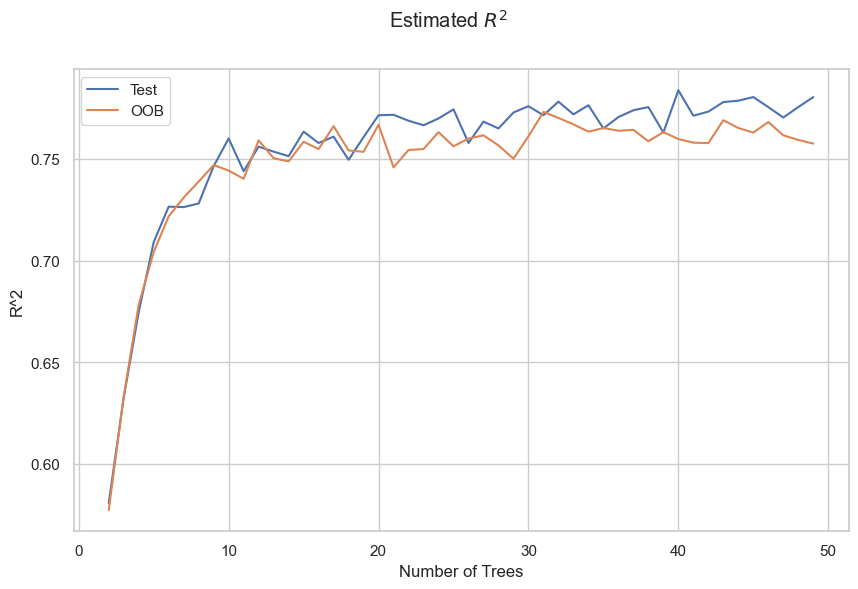

In [28]:
make_new_figure()

It can be shown that with B sufficiently large, OOB error is virtually equivalent to leave-one-out cross-validation error. The OOB approach for estimating the test error is particularly convenient when performing bagging on large data sets for which cross-validation would be computationally onerous.

### Variable Importance Measures

- Great property of random forests
- Importance of features by looking at how much the tree nodes that use that feature reduce *impurity* on average (across all trees in the forest).

- The measure relies on 
  - **regression**: the total amount of the RSS that is decreased due to splits over a given predictor, averaged over all trees. 
  - **classification**: we can add up the total amount that the Gini index is decreased by splits over a given predictor, averaged over all trees.

- A large value indicates an important predictor. 

- `SkLearn` computes this score automatically for each feature after training, 
    - results scaled to sum to 1
    - `feature_importances_`

In [29]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

In [30]:
def make_figure_feature_importance():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.set_title('Figure : Feature Importance');

    # Plot feature importance
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax)
    ax.set_xlabel('Variable Importance'); 
    plt.yticks(fontsize=14);
    plt.gca().legend_ = None;

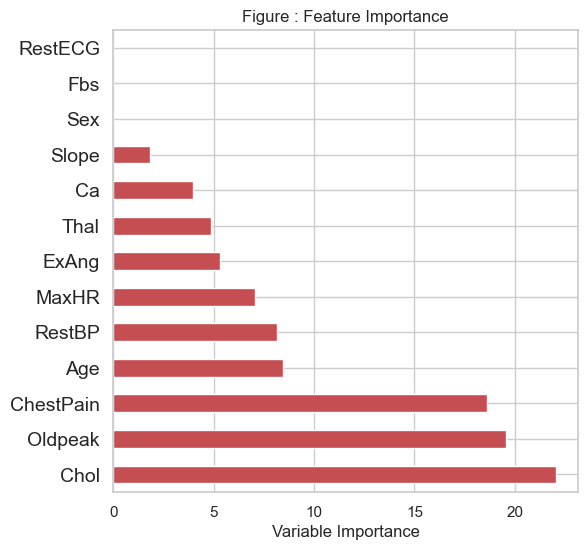

In [31]:
make_figure_feature_importance()

## XGBoost Ingredient 3 -- Random Forest
<center>
<div class="r-stack"><img src="images/xgboost_3_random_forest.png" style="height: 400px;" > </div>
</center>

### Random Forest
= an ensemble of **Decision Trees** 

1. Each tree gets its own sample of data.

2. At each tree split, a random sample of features is drawn, only those features are considered for splitting.

3. For each tree, error rate is computed using data outside its bootstrap sample.

### Random Forest classifier
Let's split the data in 2 and compute test and estimated $R^2$, for both forest and trees.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Init (takes a lot of time with J=30)
params = range(2,50)
forest_scores = np.zeros((len(params),2))
J = 30

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
        forest.fit(X2_train,y2_train)
        temp_scores[j,0] = forest.score(X2_test, y2_test)
        temp_scores[j,1] = forest.oob_score_
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

In [34]:
def make_figure_bagging_vs_rf():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure: Bagging vs Random Forest');

    # Plot scores
    ax.plot(params, bagging_scores[:,0], color='r', label='Test - Bagging');
    ax.plot(params, bagging_scores[:,1], linestyle='--', color='r', label='OOB - Bagging');
    ax.plot(params, forest_scores[:,0], color='g', label='Test - Forest');
    ax.plot(params, forest_scores[:,1], linestyle='--', color='g', label='OOB - Forest');
    ax.legend();
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('R^2');

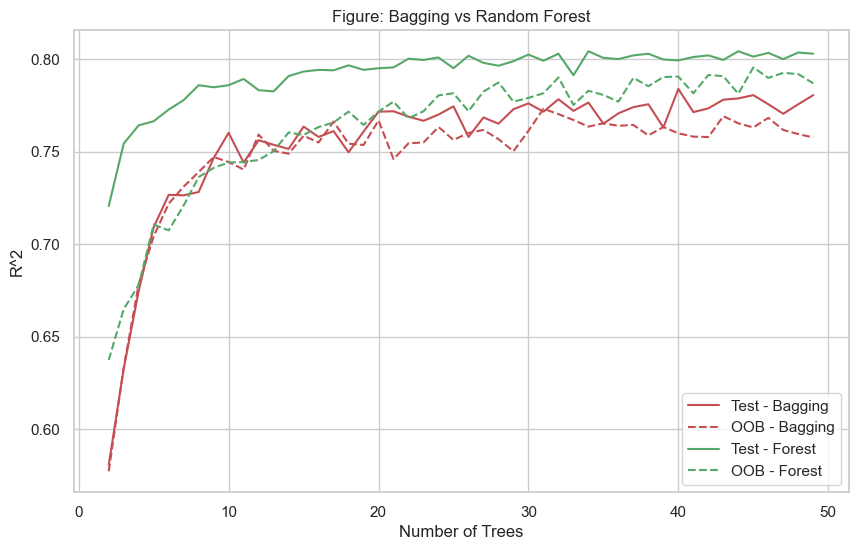

In [35]:
make_figure_bagging_vs_rf()

In [36]:
# Make new figure 2
def make_figure_feature_importance2():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

    # Plot feature importance - Bagging
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax1)
    ax1.set_xlabel('Variable Importance'); 
    ax1.set_title('Tree Bagging')

    # Plot feature importance
    h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
    h2 = h2.sort_values(by='Importance', axis=0, ascending=False)
    h2.plot(kind='barh', color='r', ax=ax2)
    ax2.set_title('Random Forest')

    # All plots
    for ax in fig.axes:
        ax.set_xlabel('Variable Importance'); 
        ax.legend([])

As for bagging, we can plot feature importance.

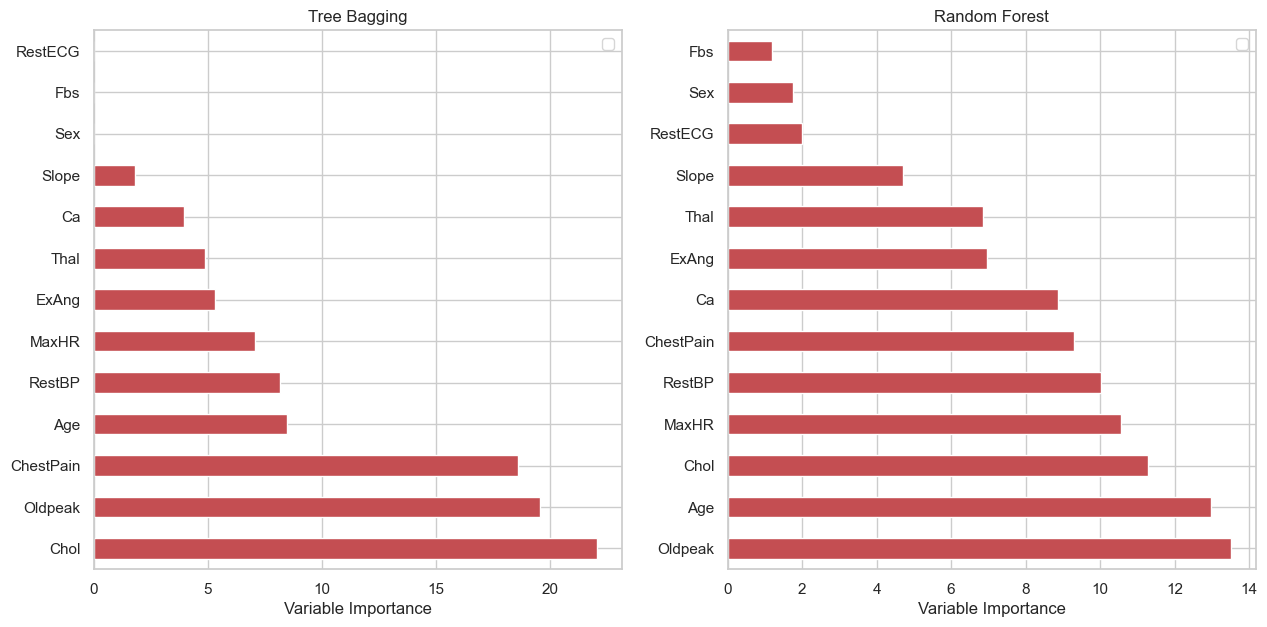

In [37]:
make_figure_feature_importance2()

## XGBoost Ingredient 4 -- Boosting
<center>
<div class="r-stack"><img src="images/xgboost_4_boosting.png" style="height: 400px;" > </div>
</center>

### Boosting

Any Ensemble method that can combine several weak learners into a strong learner

- trees are grown sequentially: each tree is grown using information from previously grown trees. 
  - Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

- Most used boosting methods:
    - *Adaptive Boosting* : `AdaBoost`
    - *Gradient Boosting*    

## XGBoost Ingredient 5 -- Gradient Boosting
<center>
<div class="r-stack"><img src="images/xgboost_5_gradient_boosting.png" style="height: 400px;" > </div>
</center>

### Gradient boosting = an additive ensemble of trees

<center>
<div class="r-stack"><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG" style="height: 400px;" > </div>
</center>

Adds additional layers of trees to fit the residuals of the first layers

- The ensemble consists of $N$ trees. 
- Tree1 is trained using the feature matrix $X$ and the labels $y$. 
- The predictions labelled $\hat y_1$ are used to determine the training set residual errors $r_1$. 
- Tree2 is then trained using the feature matrix $X$ and the residual errors $r_1$ of Tree1 as labels. 
- The predicted results $\hat r_1$ are then used to determine the residual $r_2$. 
- The process is repeated until all the $N$ trees forming the ensemble are trained.


## XGBoost Ingredient 6 -- `XGBoost`
<center>
<div class="r-stack"><img src="images/xgboost_6_xgboost.png" style="height: 300px;" > </div>
</center>

### `XGBoost` =Extreme Gradient Boosting 

$\rightarrow$ optimized implementation of Gradient Boosting

- easy to use
- actively developed
- efficient / parallelizable
- provides model explanations
- takes sparse matrices as input

In [40]:
import xgboost

xgb_reg=xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred=xgb_reg.predict(X_test)

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

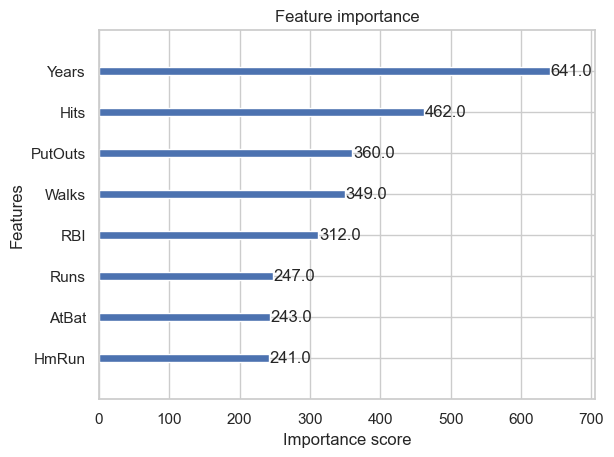

In [41]:
from xgboost import plot_importance
plot_importance(xgb_reg)

Random forests and boosted trees provide a metric of feature importance that summarizes how well each feature contributes to predictive accuracy.